In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import librosa
import numpy as np
import glob
import os
import math
import tensorflow as tf
from urllib.request import urlretrieve
import tarfile

In [5]:
def indices_to_one_hot(dta):
    one_hot = np.zeros((len(dta), len(np.unique(dta))), np.uint8)
    one_hot[np.arange(len(dta)), dta] = 1
    return one_hot

def download(url, file):
    if not os.path.isfile(file):
        print("Download file... " + file + " ...")
        urlretrieve(url,file)
        print("File downloaded")
        
def download(url, file):
    if not os.path.isfile(file):
        print("Download file... " + file + " ...")
        urlretrieve(url,file)
        print("File downloaded")

def uncompress(fname):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [7]:
if not os.path.isdir('genres'):
    download('http://opihi.cs.uvic.ca/sound/genres.tar.gz', 'genres.tar.gz')
    uncompress('genres.tar.gz')
    !rm genres.tar.gz

In [8]:
sample_rate = 11025
sample_seconds = 5 # the samples are not even so trim them down
load_per_genre = 100 # anything less than two is invalid. We need testing and training for this to functionally work
testing_threshold = 0.1 # only really makes sense if you have 10 or more but anyway
training_count = load_per_genre - math.ceil(load_per_genre * 0.1)

number_of_epochs = 10
number_per_batch = 64

print(training_count)

90


In [9]:
all_file_paths = glob.glob(os.path.expanduser("genres/*/*.au"))
number_of_files = len(all_file_paths)
genres = sorted(list(set(file_path.split("/")[1] for file_path in all_file_paths)))

print("Song genres", genres)

Song genres ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [10]:
train_data_list = []
train_labels_list = []

test_data_list = []
test_labels_list = []

for genre in genres:
    genre_files = glob.glob(os.path.expanduser("genres/" + genre + "/*.au"))
    for i, audio_file_path in enumerate(genre_files):
        raw_samples, _ = librosa.core.load(audio_file_path, sample_rate, duration=sample_seconds)
        flourier_transform = librosa.stft(raw_samples, hop_length=200)

        if i <= training_count - 1:
            train_data_list.append(flourier_transform)
            train_labels_list.append(genres.index(genre))
        else:
            test_data_list.append(flourier_transform)
            test_labels_list.append(genres.index(genre))

        if load_per_genre and i >= load_per_genre - 1:
            break

x_train = np.array(train_data_list)
y_train = indices_to_one_hot(np.array(train_labels_list))

x_test = np.array(test_data_list)
y_test = indices_to_one_hot(np.array(test_labels_list))

print("train data", x_train.shape)
print("train labels", y_train.shape)

print("test data", x_test.shape)
print("test labels", y_test.shape)

train data (900, 1025, 276)
train labels (900, 10)
test data (100, 1025, 276)
test labels (100, 10)


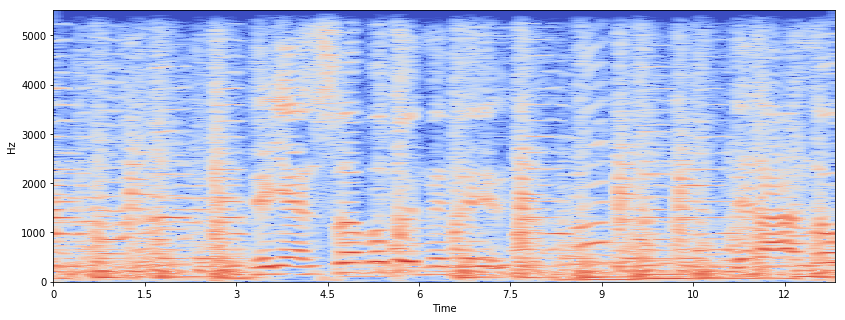

In [11]:
Xdb = librosa.amplitude_to_db(abs(x_train[8]))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')

In [12]:
# normalization
normalized_x_train = x_train.astype('float32').reshape((*x_train.shape, 1)) / 255
normalized_x_test = x_test.astype('float32').reshape((*x_test.shape, 1)) / 255

/Users/brianfletcher/anaconda3/envs/tf-cpu/lib/python3.5/site-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  
/Users/brianfletcher/anaconda3/envs/tf-cpu/lib/python3.5/site-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
print(normalized_x_train.shape)
print(normalized_x_test.shape)

(900, 1025, 276, 1)
(100, 1025, 276, 1)


In [14]:
model = tf.keras.models.Sequential()
# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=normalized_x_train[0].shape)) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
# Take a look at the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1025, 276, 64)     320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 512, 138, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512, 138, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 138, 32)      8224      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 256, 69, 32)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256, 69, 32)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 565248)            0         
__________

In [15]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [11]:
model.fit(normalized_x_train,
         y_train,
         batch_size=number_per_batch,
         epochs=number_of_epochs)

Epoch 1/10
 64/900 [=>............................] - ETA: 4696s - loss: 2.3022 - acc: 0.1406

KeyboardInterrupt: 

In [ ]:
# Evaluate the model on test set
score = model.evaluate(normalized_x_test, y_test, verbose=0)
# Print test accuracy
print('\n', 'Test accuracy:', score[1])